In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import gc_fraction
import os
import sys
import pandas as pd
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
name = os.path.join(os.path.dirname(os.getcwd()), "config")
name

'/wynton/home/ahituv/fongsl/nullomers/bin-lock/config'

In [16]:
config, cfn = crw.read_config(name)

# read
section = "MPRA_AGARWAL"
JOINT_LIBRARY = config[section]["joint_library"]
META_CELL = config[section]["all_cell_types_summary"]

# write
RE = "/wynton/home/ahituv/fongsl/nullomers/results/lock/MPRA_AGARWAL"
config["MPRA_AGARWAL"]['results'] = RE

SCAFFOLD = os.path.join(RE, "scaffolds.gc.active_inactive.all.tsv")
SAMPLED = os.path.join(RE, "scaffolds.gc.active_inactive.sampled.tsv")

scaf_section = "scaffold"

crw.check(config, scaf_section)
config[scaf_section]["sampled"] = SAMPLED
config[scaf_section]["all"] = SCAFFOLD

crw.write(config, cfn)

if os.path.exists(RE) is False:
    os.mkdir(RE)

# load library data

## function to process data
    - cell line
    - seq id
    - trim adaptors

In [4]:
def format_library(library_file):
    
    df = pd.read_csv(library_file, header=1)

    df["cl"] = df['name'].apply(lambda x: x.split("_")[0])
    
    df["seq_id"] = df['name'].apply(
        lambda x: x.split("_")[1] if '_' in x else None)
    
    df["200nt"] = df["230nt sequence (15nt 5' adaptor - 200nt element - 15nt 3' adaptor)"].apply(
        lambda x: x[15:-15])
    
    df = df.fillna(-1)
    
    df["hg38.coor"] = "chr" + df['chr.hg38'].map(str) + ":" + df["start.hg38"].map(
        int).map(str) + "-" + df["stop.hg38"].map(int).map(str)
    
    five_prime_adaptor = df["230nt sequence (15nt 5' adaptor - 200nt element - 15nt 3' adaptor)"].apply(
        lambda x: x[:15]).iloc[0]
    
    three_prime_adaptor = df["230nt sequence (15nt 5' adaptor - 200nt element - 15nt 3' adaptor)"].apply(
        lambda x: x[-15:]).iloc[0]

    print("5' adaptor", five_prime_adaptor, "3' adaptor", three_prime_adaptor)

    return df

## load it

In [5]:
df = format_library(JOINT_LIBRARY)
df.head()

5' adaptor AGGACCGGATCAACT 3' adaptor CATTGCGTGAACCGA


name                  category chr.hg19  start.hg19  stop.hg19  \
0   WTC11_seq1000_F  putative enhancer, WTC11       -1        -1.0       -1.0   
1  WTC11_seq10002_F  putative enhancer, WTC11       -1        -1.0       -1.0   
2  WTC11_seq10004_F  putative enhancer, WTC11       -1        -1.0       -1.0   
3  WTC11_seq10005_F  putative enhancer, WTC11       -1        -1.0       -1.0   
4  WTC11_seq10007_F  putative enhancer, WTC11       -1        -1.0       -1.0   

  str.hg19 chr.hg38  start.hg38   stop.hg38 str.hg38  \
0       -1        1  19461350.0  19461550.0        +   
1       -1       10  88965538.0  88965738.0        +   
2       -1       10  89029900.0  89030100.0        +   
3       -1       10  89032143.0  89032343.0        +   
4       -1       10  89111910.0  89112110.0        +   

  230nt sequence (15nt 5' adaptor - 200nt element - 15nt 3' adaptor)     cl  \
0  AGGACCGGATCAACTGTAGGACCAGGCTCTGCCTCCTTCTCTCTCC...                  WTC11   
1  AGGACCGGATCAACTTGTACTTGCCTTAGGAGGTCAAACACATTAG...                  WTC11   
2  AGGACCGGATCAACTTAGCTCAACACAAATCCATCACTGAAAGCAG...                  WTC11   
3  AGGACCGGATCAACTGACCCTAAATCAGTATGGGGAAAGGTCCCCA...                  WTC11   
4  AGGACCGGATCAACTGTGATCTCAGCTTACTGCAACCTCTGCCTCC...                  WTC11   

     seq_id                                              200nt  \
0   seq1000  GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...   
1  seq10002  TGTACTTGCCTTAGGAGGTCAAACACATTAGGTATACCAACATATC...   
2  seq10004  TAGCTCAACACAAATCCATCACTGAAAGCAGTGCAACCAAGGCAGC...   
3  seq10005  GACCCTAAATCAGTATGGGGAAAGGTCCCCACTGCAGCACTTTCTA...   
4  seq10007  GTGATCTCAGCTTACTGCAACCTCTGCCTCCTGGGTTCAAGCAATT...   

                 hg38.coor  
0   chr1:19461350-19461550  
1  chr10:88965538-88965738  
2  chr10:89029900-89030100  
3  chr10:89032143-89032343  
4  chr10:89111910-89112110

## sequence dataframe + GC

In [6]:
seqs = df[["name", "str.hg38", "hg38.coor", "200nt"]].drop_duplicates()

# get GC content
seqs["gc"] = seqs["200nt"].apply(lambda x: gc_fraction(x))
seqs = seqs.rename(columns={"str.hg38": "strand"})
seqs.head()

name strand                hg38.coor  \
0   WTC11_seq1000_F      +   chr1:19461350-19461550   
1  WTC11_seq10002_F      +  chr10:88965538-88965738   
2  WTC11_seq10004_F      +  chr10:89029900-89030100   
3  WTC11_seq10005_F      +  chr10:89032143-89032343   
4  WTC11_seq10007_F      +  chr10:89111910-89112110   

                                               200nt     gc  
0  GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...  0.615  
1  TGTACTTGCCTTAGGAGGTCAAACACATTAGGTATACCAACATATC...  0.465  
2  TAGCTCAACACAAATCCATCACTGAAAGCAGTGCAACCAAGGCAGC...  0.480  
3  GACCCTAAATCAGTATGGGGAAAGGTCCCCACTGCAGCACTTTCTA...  0.485  
4  GTGATCTCAGCTTACTGCAACCTCTGCCTCCTGGGTTCAAGCAATT...  0.505

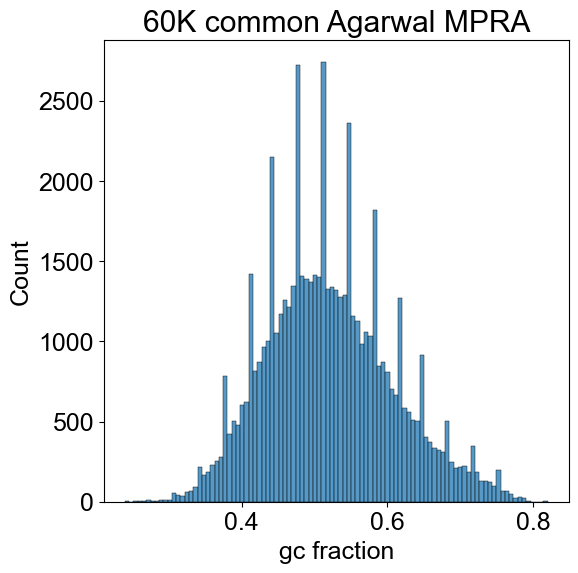

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(seqs["gc"])

ax.set(xlabel="gc fraction",
       title="60K common Agarwal MPRA"
       )

outfig = os.path.join(RE, "60K.common.GC.full.dataset.pdf")
plt.savefig(outfig, bbox_inches="tight")

# load activity data

In [8]:
act_ = pd.read_csv(META_CELL)

## format col info
    - turn into float

In [9]:
activity_cols = ['HepG2 [log2(rna/dna)]',
                 'K562 [log2(rna/dna)]', 'WTC11 [log2(rna/dna)]']

act_[activity_cols] = act_[activity_cols].astype(float)

# Activity summary stats

## IQR

In [10]:
act_.describe()

HepG2 [log2(rna/dna)]  K562 [log2(rna/dna)]  WTC11 [log2(rna/dna)]
count           56981.000000          56978.000000           56978.000000
mean               -0.192311             -0.202477              -0.554581
std                 0.744001              0.765651               1.046494
min                -2.498000             -2.364000              -3.136000
25%                -0.712000             -0.741000              -1.267000
50%                -0.322000             -0.373000              -0.854000
75%                 0.234000              0.178000              -0.149250
max                 4.983000              4.780000               6.533000

## correlation between datasets

In [11]:
act_[activity_cols].corr()

HepG2 [log2(rna/dna)]  K562 [log2(rna/dna)]  \
HepG2 [log2(rna/dna)]               1.000000              0.614042   
K562 [log2(rna/dna)]                0.614042              1.000000   
WTC11 [log2(rna/dna)]               0.493387              0.600926   

                       WTC11 [log2(rna/dna)]  
HepG2 [log2(rna/dna)]               0.493387  
K562 [log2(rna/dna)]                0.600926  
WTC11 [log2(rna/dna)]               1.000000

## plot activity distribution

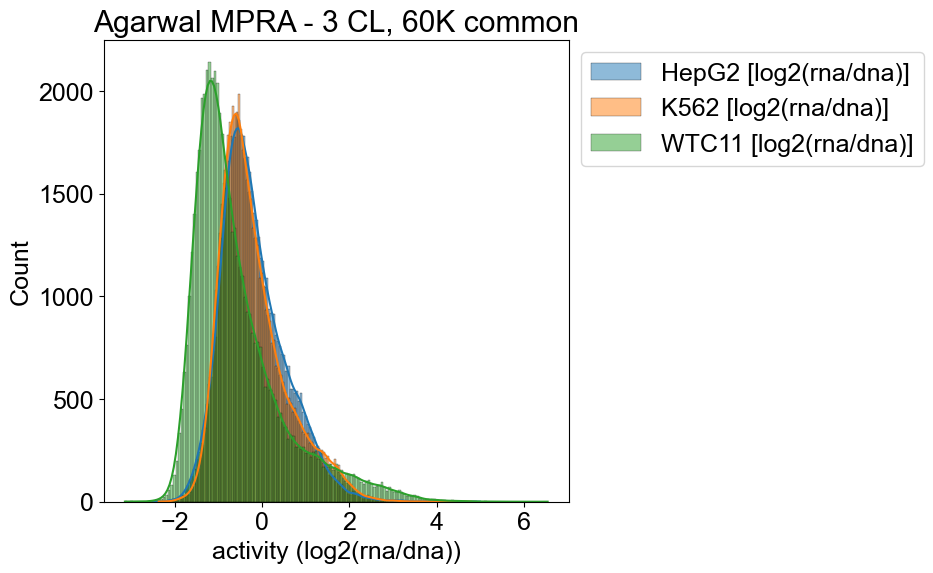

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

for col in activity_cols:
    sns.histplot(x=col, data=act_, label=col,
                 ax=ax, kde=True
                 )

ax.legend(bbox_to_anchor=(1, 1))
ax.set(
    title="Agarwal MPRA - 3 CL, 60K common",
    xlabel="activity (log2(rna/dna))"
)

# save
results_out = os.path.join(RE, "activity_dist-3_celllines.pdf")
plt.savefig(results_out, bbox_inches='tight')

# Across cell line activity

## filter for GC

In [13]:
act = pd.merge(act_, seqs, how="left")

nrows_before = act.shape[0]

act = act.loc[(act["gc"] >= 0.4) &
              (act["gc"] <= 0.6)
              ]
nrows_after = act.shape[0]
print("before, after gc filter", nrows_before,
      nrows_after, (nrows_after/nrows_before))

before, after gc filter 56981 43470 0.7628858742387814


## rank mean activity

In [14]:
act["mean_act"] = act[activity_cols].mean(axis=1)
act["mean_std"] = act[activity_cols].std(axis=1)
act["mean_rank"] = act["mean_act"].rank(pct=True)

act.sort_values(by="mean_rank").head()

name  HepG2 [log2(rna/dna)]  \
18953                  K562_peak86072                 -2.226   
17764                WTC11_seq11058_F                 -2.105   
38290  HepG2_DNasePeakNoPromoter62405                 -1.698   
7532                 WTC11_seq54206_F                 -1.940   
5416                 WTC11_seq63061_F                 -2.045   

       K562 [log2(rna/dna)]  WTC11 [log2(rna/dna)] strand  \
18953                -1.730                 -2.222      +   
17764                -1.796                 -2.236      +   
38290                -1.927                 -2.438      +   
7532                 -1.641                 -2.448      +   
5416                 -1.709                 -2.182      +   

                       hg38.coor  \
18953     chrX:44976003-44976203   
17764  chr10:120131250-120131450   
38290     chr9:61591922-61592122   
7532    chr3:177730118-177730318   
5416    chr5:166165690-166165890   

                                                   200nt     gc  mean_act  \
18953  ACCCCCTTTCTTTGCTGATAGCTTTCCTTTTGCTTAATAAATTTTG...  0.415 -2.059333   
17764  GGTCCAGGGCGGCTCCCCAGTTTCCGCTCCCTTAGGGCCTCCCCTC...  0.535 -2.045667   
38290  ATTCTATACTGTTTGCCACATATCGCTGGGTGAATTAAGCACTGTC...  0.410 -2.021000   
7532   TGAGCACATCTCATCACAGAGGCCTGCACAAAAGCCTGCTCTACCT...  0.565 -2.009667   
5416   GCTTTGGCAAGAGATTACCTGTCGATTTTTTTTCTTATTTTGTAAT...  0.425 -1.978667   

       mean_std  mean_rank  
18953  0.285218   0.000023  
17764  0.225921   0.000046  
38290  0.378850   0.000069  
7532   0.407986   0.000092  
5416   0.243377   0.000115

## pick from percentiles

In [15]:
pct_ranges = [("active", 1.0, 0.99),
              ("inactive", 0.75, 0.5),
              # ("silent", 0.05, 0)
              ]
include = ["WTC11",
           "HepG2",
           "K562",
           ]
N = 200

## randomly sample percentiles

In [18]:
if os.path.exists(SCAFFOLD) is False:
    collection = {}

    for label, high, low in pct_ranges:

        # subset dataframe by percentage range
        pop = act.loc[
            (act["mean_rank"] < high) &
            (act["mean_rank"] >= low) &
            (act["mean_std"] < 1) &
            # must be a WTC11, HepG2, or K562 sequence
            (act["name"].str.contains('|'.join(include))),
        ].copy()

        # label activity
        pop["scaffold_activity"] = label

        # label randomly sampled
        pop["sampled"] = "not.sampled"

        sample = pop['name'].sample(N)
        pop.loc[pop["name"].isin(sample), "sampled"] = "sampled"

        collection[label] = pop

    test = pd.concat(collection.values())

    print(test.shape)

    # join sampled with rest of dataframe.
    act = pd.concat([act, test])
    act["scaffold_activity"] = act["scaffold_activity"].fillna("not.labeled")
    act["sampled"] = act["sampled"].fillna("not.sampled")
    act['joint_scaffold_activity.sampled'] = act["scaffold_activity"] + \
        "." + act["sampled"]

    # add scaffold sequences
    act = pd.merge(act, seqs, how="left")

    # write
    if os.path.exists(SAMPLED) is False:
        act.loc[act['sampled'] == "sampled"].to_csv(
            SAMPLED, sep='\t', index=False)

    if os.path.exists(SCAFFOLD) is False:
        act.to_csv(SCAFFOLD, sep='\t', index=False)
else:
    act = pd.read_csv(SCAFFOLD, sep='\t',)
act.head()

name  HepG2 [log2(rna/dna)]  K562 [log2(rna/dna)]  \
0  WTC11_seq9998_F                 -1.018                -1.018   
1  WTC11_seq9987_F                  0.320                -0.439   
2   WTC11_seq998_F                  0.003                -0.217   
3   WTC11_seq998_F                  0.003                -0.217   
4  WTC11_seq9970_F                 -0.794                -1.026   

   WTC11 [log2(rna/dna)] strand  \
0                 -1.254      +   
1                 -1.505      +   
2                 -0.462      +   
3                 -0.462      +   
4                 -1.414      +   

                                               200nt     gc  mean_act  \
0  GCACCCTTCCCAGAAATTTTGACTCAGTGGGGCCTAGAAATCTGTG...  0.530 -1.096667   
1  CTGATTATATTAAAAAAAAAAGCTCTTTAGGTTTCCTGGCTCTATC...  0.425 -0.541333   
2  AACAGAGGAAGCTGGAGGCCTCTCGGCATCACCTGGACAAACAGCC...  0.590 -0.225333   
3  AACAGAGGAAGCTGGAGGCCTCTCGGCATCACCTGGACAAACAGCC...  0.590 -0.225333   
4  AATATGATTGAATGGATCTGTGTTGGGGAATGGAGGCAGTCTTCAA...  0.455 -1.078000   

   mean_std  mean_rank scaffold_activity      sampled  \
0  0.136255   0.073096       not.labeled  not.sampled   
1  0.916794   0.445054       not.labeled  not.sampled   
2  0.232612   0.668277       not.labeled  not.sampled   
3  0.232612   0.668277          inactive  not.sampled   
4  0.313254   0.080055       not.labeled  not.sampled   

  joint_scaffold_activity.sampled                hg38.coor  
0         not.labeled.not.sampled  chr10:88892273-88892473  
1         not.labeled.not.sampled  chr10:88524112-88524312  
2         not.labeled.not.sampled   chr1:19445991-19446191  
3            inactive.not.sampled   chr1:19445991-19446191  
4         not.labeled.not.sampled  chr10:87675767-87675967

## summarize sampling numbers

In [19]:
act.groupby(["scaffold_activity", "sampled"])["mean_act"].mean()

scaffold_activity  sampled    
active             not.sampled    2.040704
                   sampled        2.133115
inactive           not.sampled   -0.290889
                   sampled       -0.293273
not.labeled        not.sampled   -0.351431
Name: mean_act, dtype: float64

In [ ]:
act.groupby(["scaffold_activity", "sampled"])["name"].count()

## plot

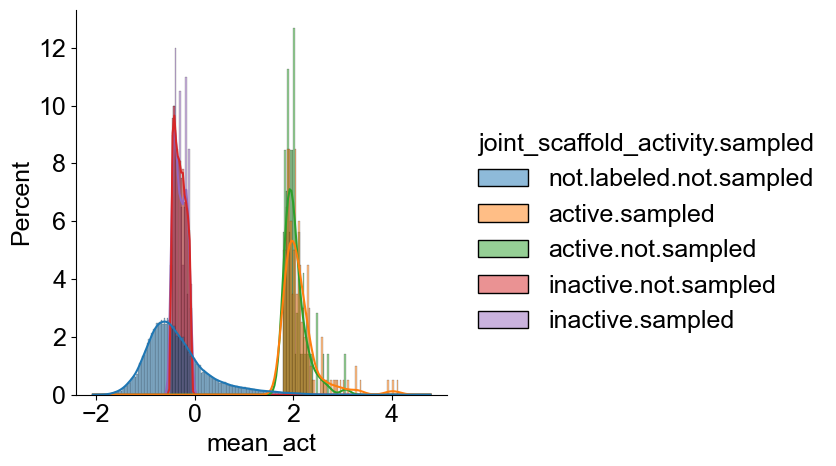

In [54]:
x = "mean_act"
data = act
hue = "joint_scaffold_activity.sampled"
# fig, ax = plt.subplots(figsize=(8,8))
sns.displot(x=x,
            data=data,
            hue=hue,
            stat='percent',
            common_norm=False,
            kde=True,
            )


plt.title = f"sampling {N} Agarwal MPRA - 3 CL, 60K common",
plt.xlabel = "activity (log2(rna/dna))"


# save
results_out = os.path.join(RE, f"activity_dist-3_cell-lines.sample.{N}.pdf")
plt.savefig(results_out, bbox_inches='tight')

(400, 12)

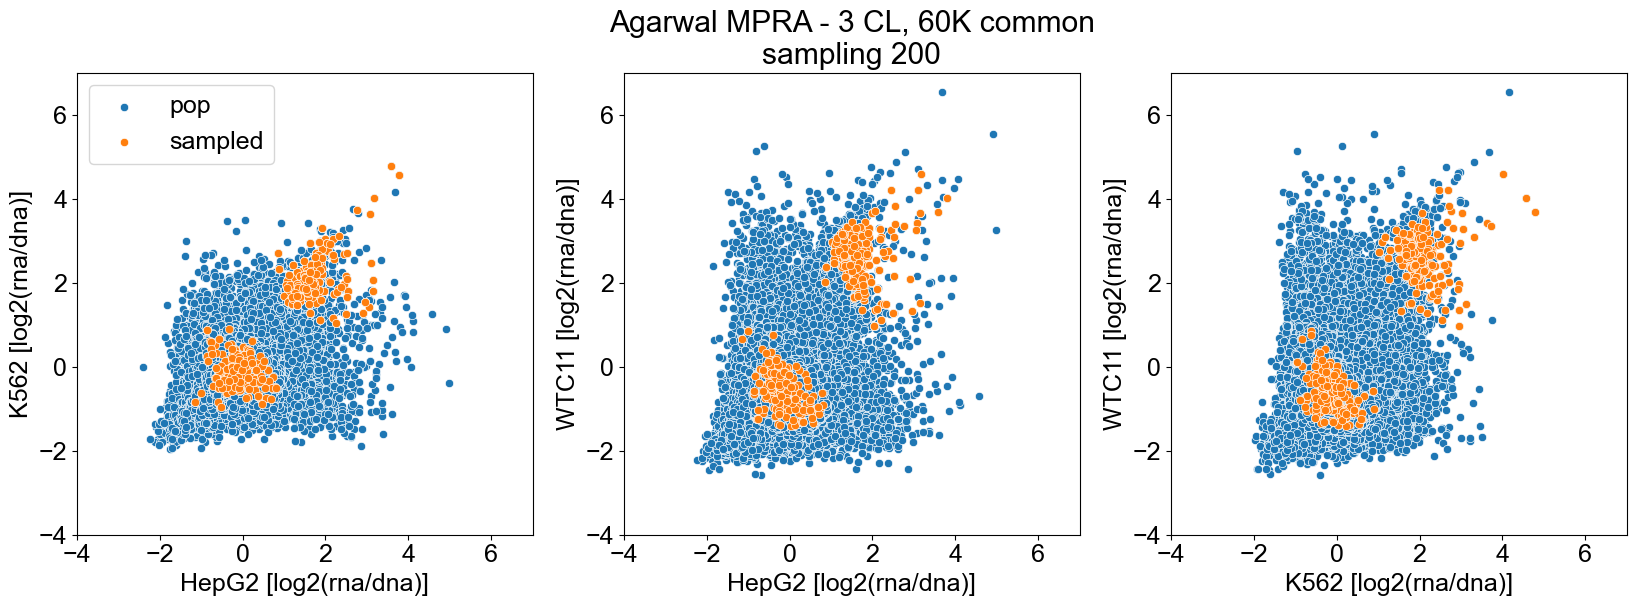

In [55]:
combos = [(0, 1), (0, 2), (1, 2)]


fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 6))
axs = [ax1, ax2, ax3]
n = 0
for nx, ny in combos:
    for data in [act, test.loc[test['sampled'] == "sampled"]]:

        x = activity_cols[nx]
        y = activity_cols[ny]
        ax = axs[n]

        sns.scatterplot(
            x=x,
            y=y,
            data=data,
            ax=ax,
            # alpha=0.5
            # hue="scaffold_activity"
        )

        ax.set(
            xlim=(-4, 7),
            ylim=(-4, 7)

        )
        if n == 0:
            ax.legend(["pop", "sampled"], loc='upper left')
        if n == 1:
            ax.set(title=f"Agarwal MPRA - 3 CL, 60K common\nsampling {N}",)
    n += 1


# save
results_out = os.path.join(RE, f"activity_dist-3_cell-lines.sample.{N}.pdf")
plt.savefig(results_out, bbox_inches='tight', dpi=50)


data.shape

#  gc content

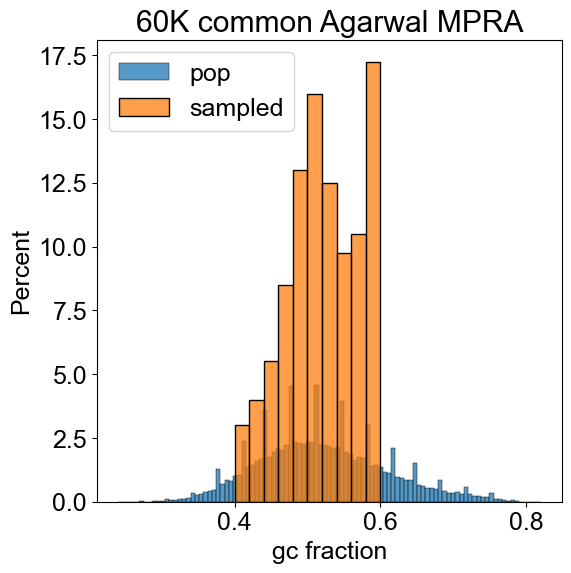

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(seqs["gc"], label="pop",
             stat="percent", common_norm=False)
sns.histplot(test.loc[test['sampled'] == "sampled", "gc"],
             label="sampled", stat="percent", common_norm=False)

ax.set(xlabel="gc fraction",
       title="60K common Agarwal MPRA"
       )
ax.legend()
outfig = os.path.join(RE, "60K.common.GC.full.sampled.dataset.pdf")
plt.savefig(outfig, bbox_inches="tight")

# PCA

In [62]:
pca = PCA(n_components=2)

## run PCA on MPRA activity only

In [63]:
act.head()

name  HepG2 [log2(rna/dna)]  K562 [log2(rna/dna)]  \
0  WTC11_seq9998_F                 -1.018                -1.018   
1  WTC11_seq9987_F                  0.320                -0.439   
2   WTC11_seq998_F                  0.003                -0.217   
3   WTC11_seq998_F                  0.003                -0.217   
4  WTC11_seq9970_F                 -0.794                -1.026   

   WTC11 [log2(rna/dna)] strand  \
0                 -1.254      +   
1                 -1.505      +   
2                 -0.462      +   
3                 -0.462      +   
4                 -1.414      +   

                                               200nt     gc  mean_act  \
0  GCACCCTTCCCAGAAATTTTGACTCAGTGGGGCCTAGAAATCTGTG...  0.530 -1.096667   
1  CTGATTATATTAAAAAAAAAAGCTCTTTAGGTTTCCTGGCTCTATC...  0.425 -0.541333   
2  AACAGAGGAAGCTGGAGGCCTCTCGGCATCACCTGGACAAACAGCC...  0.590 -0.225333   
3  AACAGAGGAAGCTGGAGGCCTCTCGGCATCACCTGGACAAACAGCC...  0.590 -0.225333   
4  AATATGATTGAATGGATCTGTGTTGGGGAATGGAGGCAGTCTTCAA...  0.455 -1.078000   

   mean_std  mean_rank scaffold_activity      sampled  \
0  0.136255   0.073096       not.labeled  not.sampled   
1  0.916794   0.445054       not.labeled  not.sampled   
2  0.232612   0.668277       not.labeled  not.sampled   
3  0.232612   0.668277          inactive  not.sampled   
4  0.313254   0.080055       not.labeled  not.sampled   

  joint_scaffold_activity.sampled  
0         not.labeled.not.sampled  
1         not.labeled.not.sampled  
2         not.labeled.not.sampled  
3            inactive.not.sampled  
4         not.labeled.not.sampled

In [64]:
act[["mean_act"]]

mean_act
0     -1.096667
1     -0.541333
2     -0.225333
3     -0.225333
4     -1.078000
...         ...
53026 -0.476000
53027 -0.278000
53028 -0.661000
53029 -0.231667
53030 -0.182333

[53031 rows x 1 columns]

In [65]:
act[act.columns[1:4]]

HepG2 [log2(rna/dna)]  K562 [log2(rna/dna)]  WTC11 [log2(rna/dna)]
0                     -1.018                -1.018                 -1.254
1                      0.320                -0.439                 -1.505
2                      0.003                -0.217                 -0.462
3                      0.003                -0.217                 -0.462
4                     -0.794                -1.026                 -1.414
...                      ...                   ...                    ...
53026                  1.479                -1.133                 -1.774
53027                  2.147                -1.195                 -1.786
53028                  1.249                -1.464                 -1.768
53029                  2.050                -1.122                 -1.623
53030                  1.636                -0.835                 -1.348

[53031 rows x 3 columns]

In [66]:
act = act.loc[~act[act.columns[3]].isna()]
X,y = act[act.columns[1:4]], act["mean_act"]

X.shape

(53029, 3)

In [67]:
Xt = pca.fit_transform(X)

pca.explained_variance_ratio_

array([0.66826806, 0.21495643])

In [68]:
features =["mean_act", "mean_rank", "gc"]

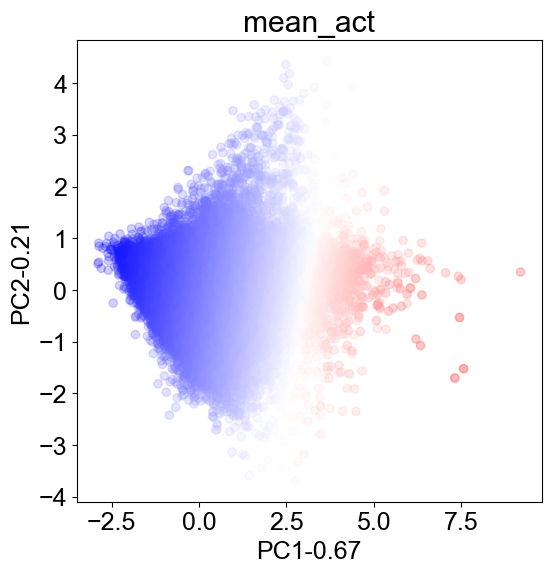

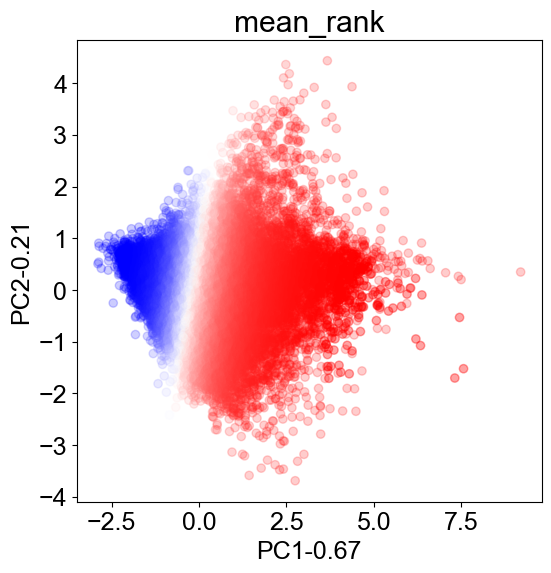

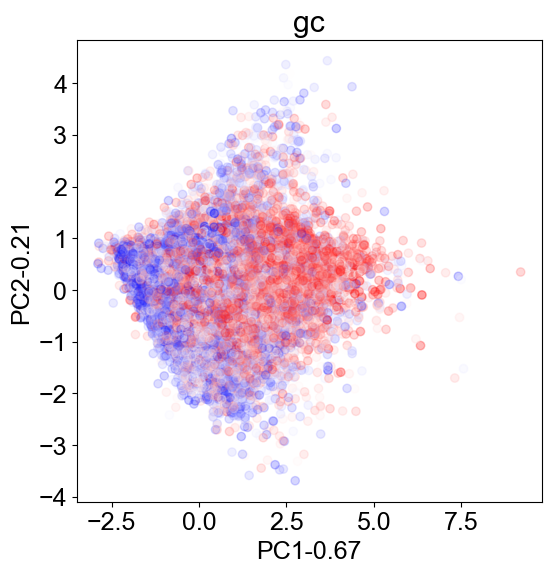

In [69]:
for feature in features:
    y = act[[feature]]
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.scatter(np.array(Xt)[:, 0], np.array(Xt)[:, 1],
                c=(y[feature]),
                cmap="bwr", alpha=0.2)

    # plt.legend([ "null"],bbox_to_anchor=(1,1))
    ax.set(xlabel=f"PC1-{round(pca.explained_variance_ratio_[0],2)}",
           ylabel=f"PC2-{round(pca.explained_variance_ratio_[1],2)}",
           title=feature
           )

# sequence identity

In [107]:
from Bio.Align import PairwiseAligner


def withinAlignList(l1):
    l2 = l1[::]
    np.random.shuffle(l1)  # shuffle the first list
    scores = []
    for s1 in l1:
        for s2 in l2:
            if s2 != s1:
                score = PairwiseAlign(s1, s2)
                scores.append(score)

    return scores


def PairwiseAlign(seq1, seq2):

    aligner = PairwiseAligner()

    alignment = aligner.align(seq1, seq2)  # [:-3] ignores the pam site

    return alignment.score

In [108]:
sampled = act.loc[act['sampled']=="sampled"].copy()
random = act.sample(n=500)

In [109]:
l1 = list(sampled["200nt"])
sampled_scores = withinAlignList(l1)

In [110]:
r1 = list(random["200nt"])
random_scores = withinAlignList(r1)

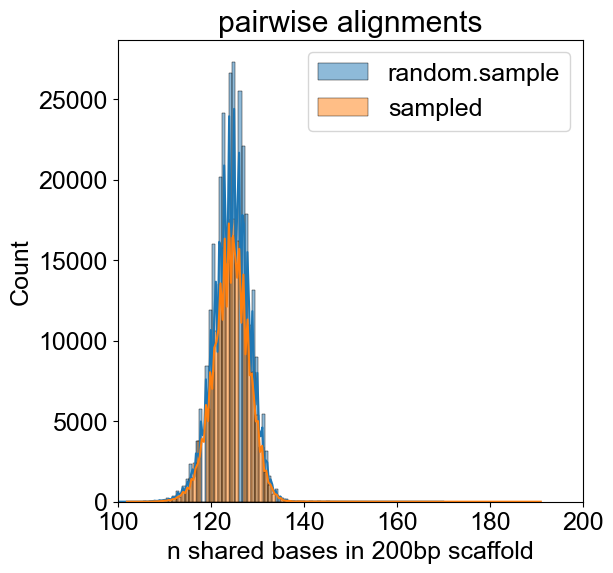

In [141]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(random_scores, label="random.sample",
             kde=True, bins=100, common_norm=False)
sns.histplot(sampled_scores, label="sampled",
             kde=True, bins=100, common_norm=False)
ax.set(
    title="pairwise alignments",
    xlabel="n shared bases in 200bp scaffold",
    xlim=(100, 200)
)
ax.legend()
outfig = os.path.join(
    RE, "60K.common.GC.sampled.pariwise.sequence.identity.pdf")
plt.savefig(outfig, bbox_inches="tight")

In [134]:
min(random_scores), min(sampled_scores), max(random_scores), max(sampled_scores)

(99.0, 102.0, 170.0, 191.0)